# **Motivation**
As in each system, breakdowns and errors sometimes occur in **dCahce**. Few people would dispute that it is important to detect them automatically and warn users afterward. Imagine the situation, a scientist from Japan failed to access data from the node placed in the mid-Europian region, and now he is trying to figure out if there was a problem with his local machine or with the entire system, but he can not get any information, because due to the difference in time zones local office in Europe is closed already. In such cases, it is especially important to warn the user if something was wrong. That is why we decided to develop a **machine learning** model, helping to detect undesirable situations.
  
This report is devoted to our solution for this problem. We have prepared the model, analysing information about dCache transactions and  distinguishing `signal` - when the system works fine and `backgorund` - when something goes wrong. You can find a more detailed description on the following pages of the report.
 

# **1. Introduction**
## **1.1. dCache**
   First of all, it worths saying some words about the system we are going to work with -  dCache. Built in Java dCache is a distributed mass-storage system that allows us to manage huge ammount of scientific data. The data are distributed among the large number of heterogenous pools(nodes) that handle with data storage and transfer. A client can easily get access to dCache data through requests.  
   
   Information we are intersted in is about transactions occurred in dCache. It is contained in *billing* files which are a set of JSON dictionaries for a particular date. There are several main types of transactions: requset, transfer, remove, store, restore, but  only `stores` will be in our sphere of interests (later will be explained why).

   Since amount of data to process is huge enough, to avoid overloading of our local machines we use unified analytics engine for large-scale data processing - **Apache Spark**.
   

## **1.2. Apache Spark**

**Apache Spark** is an open-source, distributed processing system used for big data workloads. It utilizes in-memory caching, and optimized query execution for fast analytic queries against data of any size. [1.]

Spark was introduced in 2012. Before Spark, Hadoop MapReduce was commonly used for big data analytics. 

Hadoop MapReduce processes big datasets with a parallel, distributed algorithm. However, a challenge in using MapReduce is the sequential multi-step process it takes to run a job. With each step requiring a disk read, and write, MapReduce jobs are slower due to the latency of disk I/O.

To overcome this problem, Spark was created. It achieves this by processing in-memory, reducing the number of steps in a job, and by reusing data across multiple parallel operations. It is accomplished through the creation of DataFrames, an abstraction over Resilient Distributed Dataset (RDD), which is a collection of objects that is cached in memory, and reused in multiple Spark operations.

## **1.3. Machine Learning**

**Machine learning(ML)** is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems.  [2.]

Broadly, there are mainly 3 types of ML algorithms:

* Supervised Learning: When an algorithm learns from example data and associated target responses that can consist of numeric values or string labels, such as classes or tags, in order to later predict the correct response when posed with new examples comes under the category of Supervised learning.

* Unsupervised learning: When an algorithm learns from plain examples without any associated response, leaving to the algorithm to determine the data patterns on its own.

* Reinforcement learning: When you present the algorithm with examples that lack labels, as in unsupervised learning. However, you can accompany an example with positive or negative feedback according to the solution so that the algorithm makes its own decisions, and the decisions bear consequences.

<a href="https://ibb.co/sH5Nv38"><img src="https://i.ibb.co/YZD17jH/figure01.png" alt="figure01" border="0"></a>

Source: [Link](https://developer.ibm.com/articles/cc-models-machine-learning/)

## **1.4. Logistic Regression**

Logistic Reression is a type of Supervised Algorithm that is used for classification problems, i.e. correctly classifying various data points to their correct data labels. It calculates the probability of the datasample being a particular class. 

In our project, we have worked with binary class Logistic Regression Model which classifies 2 Labels 0 and 1.

The conditional probability that our Logistic model gives a particular class given the dataset is given by -

<a href="https://ibb.co/vXSL8Xr"><img src="https://i.ibb.co/XYqFTYd/1-I0l-W7-Ydv-Tn3m-HXh56p-Yx-ZQ.gif" alt="1-I0l-W7-Ydv-Tn3m-HXh56p-Yx-ZQ" border="0"></a>

where

* w = weight values which are determined by our ML algorithm

* x = data input

* y = conditional probability of predicting a particular class given the dataset

Plot of y with a one dimensional data input x will have the following form - 

<a href="https://ibb.co/sg1spY7"><img src="https://i.ibb.co/GdMCfSm/1-Un-SW1b5-Ldp-Fl-Bx5h-R54-J0w.png" alt="1-Un-SW1b5-Ldp-Fl-Bx5h-R54-J0w" border="0"></a>

Source: [Link](https://towardsdatascience.com/an-introduction-to-logistic-regression-8136ad65da2e)

If the y value for a particular instance is greater than the model's threshold, Logistic Regression predicts it as a positive instance (class 1), otherwise as a negative one (class 0). Default model's threshold equals 0.5.

# **2. Analysis**
## **2.1. Importing Libraries and setting up the Spark Configuration**
The following libraries and Spark Configurations were used:

In [1]:
import findspark
findspark.init()
import os
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from urllib.request import urlopen

sc_conf = SparkConf().setMaster('spark://dcache-dot1.desy.de:5000').set('spark.executor.memory',
'26G').set('spark.driver.memory','8G').set('spark.driver.maxResultSize','8G')
#sc = SparkContext(appName="PythonStreaming")
sc = SparkContext(conf = sc_conf)
sqlContext = SQLContext(sc)

## **2.2. Data Pre-Selection**
As was said before, we were interested in only `store` type of transactions. There are two main reasons for it. First - structure of messages with type `store` is not really complicated, there are not many features to analyze in comparison with `transfer`, for instance. Second - there are sufficient number of instances with message type `store` in dCache.

Two random days were chosen for analysis: 2021-07-10 and 2021-08-01. For converting data to RDD we wrote special function `convert_data`. As you may see, there are two parametrs in it: `file` - a file's directory, `msgType` - type of a message.

In [2]:
def convert_data(file, msgType):
    data = sc.textFile(file)
    billing = data.map(lambda row: json.loads(row)).filter(lambda row: row.get('msgType',None) == msgType)
    return billing

To combine data from both days SparkContext method *union()* was used:

In [3]:
billing_RDD = sc.union(
    [
        convert_data('/pnfs/desy.de/desy/dcache-operations/billing-archive/xfel/2021/07/billing-2021-07-10.json',"store"),
        convert_data('/pnfs/desy.de/desy/dcache-operations/billing-archive/xfel/2021/08/billing-2021-08-01.json',"store")
    ]
)

## **2.3. Feature Description**

After selecting the msgType = "Store", we can see that the RDD has many columns of data. 

All the columns along with an example, can be seen using the following code.

In [4]:
billing_RDD.first()

{'transferTime': 23,
 'version': '1.0',
 'date': '2021-07-10T02:01:27.432+02:00',
 'cellDomain': 'dcache-xfel132-06Domain',
 'pnfsid': '00005F97A5611EE74DE68C4EFB82451E8ADD',
 'transaction': 'pool:dcache-xfel132-06@dcache-xfel132-06Domain:1625875287432-12713',
 'status': {'code': 66, 'msg': 'HSM script failed (script reported: 66: )'},
 'msgType': 'store',
 'fileSize': 9514620780,
 'billingPath': '/pnfs/desy.de/exfel/archive/XFEL/proc//SPB/201701/p002038/r0220/CORR-R0220-AGIPD04-S00003.h5',
 'storageInfo': 'xfel:SPB-201701PROC@osm2',
 'queuingTime': 0,
 '@version': '1',
 '@timestamp': '2021-07-10T00:01:27.457Z',
 'tags': ['xfel'],
 'cellType': 'pool',
 'session': 'pool:dcache-xfel132-06@dcache-xfel132-06Domain:1625875287432-12713',
 'cellName': 'dcache-xfel132-06'}

However, all this columns are not required for our ML analysis. So, we have selected few columns which we deemed important for our task of Anomaly Detection.

All the other columns were rejected because they were unique label to each event and thus wouldn't provide much insight into the Anomaly Detection algorithm that we are trying to construct.

| Features | Description |
|----------|-------------|
| CellName |             |
|          |             |
|          |             |

## **2.4. Data Pre-Processing**

Before the data can be used for our ML purposes it has to be transformed so that they are suitable for applying our ML algorithm.

We use some wrapper functions to do some initial transformations.

* Queueing Time - No modification **(with modifications, isn't it?)**

In [5]:
def cellName(cellName):
    s=cellName[len(cellName)-5:]
    s1=s.split('-')
    return str(s1[0])+str(s1[1])

def date_time(date):
    return int(time.mktime(parser.parse(date).timetuple()))

def fileSize(fileSize):
    return float(np.log(fileSize))

def queuingTime(queuingTime):
    if (queuingTime == 0) | (queuingTime is None):
        return -10.0
    else:    
        return float(np.log(queuingTime))
    
def transferTime(transferTime):
    return float(np.log(transferTime))

def initial_label(status):
    if status['code']!=0:
        return 1
    else:
        return 0

In [6]:
billing_Schema =  StructType([
    StructField('cellName', StringType(), True),
    StructField('date_time', LongType(), True),
    StructField('fileSize', FloatType(), True),
    StructField('transferTime', FloatType(), True),
    StructField('queuingTime', FloatType(), True),
    StructField('initial_label', LongType(), True)
   ])

def parse_billing(entry):
    parse_list = [ cellName(entry.get('cellName')),
                   date_time(entry.get('date')),
                   fileSize(entry.get('fileSize')),
                   transferTime(entry.get('transferTime')),
                   queuingTime(entry.get('queuingTime')),
                   initial_label(entry.get('status'))
                  ]
    info = tuple( field for field in parse_list )
    return info

billing_df = sqlContext.createDataFrame(billing_RDD.map(lambda s: parse_billing(s)), billing_Schema)
billing_df.createOrReplaceTempView("billing_desy") #name creation for sql quiries
billing_df.cache()

DataFrame[cellName: string, date_time: bigint, fileSize: float, transferTime: float, queuingTime: float, initial_label: bigint]

In [7]:
billing_df.printSchema()

root
 |-- cellName: string (nullable = true)
 |-- date_time: long (nullable = true)
 |-- fileSize: float (nullable = true)
 |-- transferTime: float (nullable = true)
 |-- queuingTime: float (nullable = true)
 |-- initial_label: long (nullable = true)



We have one column `cellName` which has 'String' type. Since, a 'String' type column can't directly be used for any ML analysis, we have to convert it into a suitable form.

We use the `StringIndexer` module in Mllib followed by the `OneHotEncoder` module, which transforms the CellName columns into a sparse matrix which can then be used for ML analysis.

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
str_columns=['cellName']
string_indexer=[ StringIndexer(inputCol=x, outputCol=x+'_StringIndexer', handleInvalid='skip') for x in str_columns]
one_hot_encoder=[OneHotEncoder(inputCol=f"{x}_StringIndexer", outputCol=f"{x}_OneHotEncoder") for x in str_columns]

To be able to apply Logistic Regression on our data we have to convert the DataFrame into a single vector of features called 'features' which is achieved by the `Vectorizer` module in Mllib.

In [9]:
from pyspark.ml.feature import VectorAssembler
num_columns=['fileSize', 'transferTime', 'queuingTime']
assembler_input=num_columns+[f"{x}_OneHotEncoder" for x in str_columns]
vector_assembler=VectorAssembler(inputCols=assembler_input, outputCol='features')

Note, that `date_time` field was not included in the vector of features. That is because `date_time` is a unique feature for each file, which does not provide an ML model with important information. However, it plays a crucial role in data sampling (later will be shown how), that is why we did not exclude `date_time` from the list of fields. 

## **2.5. Data Sampling and Labeling**
Since, we had 2 classes to distinguish - `signal` and `background`, we had to use a classification model for our problem.

Before starting to apply machine learning for classifictaion, it is essetial to prepare data samples and label instances correctly. 

First of all, we would like to describe labeling of the data instances. Initial approach with using `status_code` feature (look at the `initial_label` field, point 2.5) is a bit naive to make a decision if a particular instance is a part of background or signal. So, we have developed more sophisticated algorithm. New labeling algorithm includes two steps:
* Using `date_time` field, we divide all available time (for two chosen dates) on a particular number of bins, each bin equals one hour of time. 
* Averaging values of the field `initial_label` for a particular bin, we compare output value with the threshold (threshold=0.5 in our case). If the averaged value is less than the threshold we consider all instances as signal (fill 0 as the `label` for each instance of the bin), otherwise as background (fill 1 as the the `label` for each instance of the bin).

The second issue is how to sample the data. For comparison we decided to apply two ways:
* Extracting first 70 % instances for each hour sequently (serial way) 
* Extracting  70 % instances for each hour randomly (random way)

Code examples, including labeling and two ways of the data selection, are represented below:

In [10]:
treshhold=0.5

#finding of minimum value for date_time in the initial data frame
min_val=sqlContext.sql("select MIN(date_time) from billing_desy").collect()
min_val=np.array(min_val)[0]

#finding of maximum value for date_time in the initial data frame
max_val=sqlContext.sql("select MAX(date_time) from billing_desy").collect()
max_val=np.array(max_val)[0]

#calculating number of hours
bin_num=np.round((max_val-min_val)/3600,0)

In [11]:
"""serial way"""

#importing lit for labeling
from pyspark.sql.functions import lit

#creation of an empty data frame for followed union
billing_Schema_empty =  StructType([
    StructField('cellName', StringType(), True),
    StructField('date_time', LongType(), True),
    StructField('fileSize', FloatType(), True),
    StructField('transferTime', FloatType(), True),
    StructField('queuingTime', FloatType(), True),
    StructField('initial_label', LongType(), True),
    StructField('label', IntegerType(), True)
   ])
serial_df=sqlContext.createDataFrame(sc.emptyRDD(), billing_Schema_empty)
    
for i in range(int(bin_num)):
    #spliting by hours
    new_df=sqlContext.sql("select * from billing_desy where date_time between {} and {} order by date_time DESC".format(
        int(min_val)+3600*i,int(min_val)+3600*(i+1)))
    new_avg=sqlContext.sql("select AVG(initial_label) from billing_desy where date_time between {} and {}".format(
        int(min_val)+3600*i,int(min_val)+3600*(i+1))).collect()
    new_avg=np.array(new_avg)[0][0]
    
    if new_avg is None:
        continue
        
    else:
        new_avg=float(new_avg)
        
        #serial extracting
        per_70=new_df.take(int(np.round(0.7*new_df.count(),0))+1)
        per_70_df=sqlContext.createDataFrame(per_70)
    
    #labeling
    if new_avg>=treshhold:
        per_70_df=per_70_df.withColumn("label", lit(1))
    else:
        per_70_df=per_70_df.withColumn("label", lit(0))
    serial_df=serial_df.union(per_70_df)


In [12]:
#distribution of signal(0) and background(1) instances for serial sampling
serial_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|10251|
|    0|12108|
+-----+-----+



In [13]:
"""random way"""

#creation of empty dataframe for followed union
billing_Schema_empty =  StructType([
    StructField('cellName', StringType(), True),
    StructField('date_time', LongType(), True),
    StructField('fileSize', FloatType(), True),
    StructField('transferTime', FloatType(), True),
    StructField('queuingTime', FloatType(), True),
    StructField('initial_label', LongType(), True),
    StructField('label', IntegerType(), True)
   ])
rand_df=sqlContext.createDataFrame(sc.emptyRDD(), billing_Schema_empty)
    
for i in range(int(bin_num)):
    #spliting by hours
    new_df=sqlContext.sql("select * from billing_desy where date_time between {} and {} order by date_time DESC".format(
        int(min_val)+3600*i,int(min_val)+3600*(i+1)))
    new_avg=sqlContext.sql("select AVG(initial_label) from billing_desy where date_time between {} and {}".format(
        int(min_val)+3600*i,int(min_val)+3600*(i+1))).collect()
    new_avg=np.array(new_avg)[0][0]
    
    if new_avg is None:
        continue
        
    else:
        new_avg=float(new_avg)
        
        #random extracting
        rand_70_df, rand_30_df= new_df.randomSplit([0.7,0.3],seed=7)
        
    #labeling
    if new_avg>=treshhold:
        rand_70_df=rand_70_df.withColumn("label", lit(1))
    else:
        rand_70_df=rand_70_df.withColumn("label", lit(0))
        
    rand_df=rand_df.union(rand_70_df)


In [14]:
#distribution of signal(0) and background(1) instances for random sampling
rand_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|10176|
|    0|12072|
+-----+-----+



## **2.6. Algorithm Selection**
Having prepared data, chosen samples and labeled instances, we are able to apply machine learning algorithms. We decided to choose `Logistic Regression` as our Classifier model because of the following reasons:
* Since the model's mathematical algorithm is not very complicated (look at point 1.4), Logistic Regression is easy to train and fast in predictions.
* Logistic Regression scales well to large datasets.
* Logistic Regression is able to give probabilities for each predicted class as output explicitly.
* Reasons for the model's predictions are relatively easy to interpret.

We used the `Mllib` module that is availaible with spark to perform our analysis.

To combine all steps of the data pre-processing (look at point 2.5) and not to do them separately each time, we used `Pipline`. Output data of `Pipline` model are appropriate for the training of `Logistic Regression` model. Code goes below:

In [15]:
#splitting of selected data on train and test samples (serial_df for sequential selection is in this exaple, rand_df is also possible)
train, test= serial_df.randomSplit([0.7,0.3],seed=7)

#designation of stages for Pipline
stages=[]
stages+=string_indexer
stages+=one_hot_encoder
stages+=[vector_assembler]

#Pipline model creation
from pyspark.ml import Pipeline
pipeline=Pipeline().setStages(stages)
model=pipeline.fit(train)

#transforming of the train sample for Logistic Regression
X_train=model.transform(train)
X_train.createOrReplaceTempView("X_train")
data=sqlContext.sql("select distinct(features),label from X_train")

#training of Logistic Regression model
from pyspark.ml.classification import LogisticRegression
lr=LogisticRegression().fit(data)

## **2.7. The model evaluation**
Before representing the results, it is worth saying some words about how we evaluated the model. 

To check the quality of the model's performance we split prepared datasets on `train sample`, used for model fitting, and `test sample`, used for model evaluation, in the proportion of `70%` and `30 %` accordingly (look at the cell below).

In [16]:
train, test= serial_df.randomSplit([0.7,0.3],seed=7) #or random_df.randomSplit(...)

To understand evaluation metrics description, it is necessary to keep in mind two simple things. First, all predictions can be divided into two classes - **correct** ones and **incorrect** ones. Second, there are two types of correct predictions:`true positive (TP)`, `true negative (TN)`; and two types of incorrect ones: `false positive (FP)` and `false negative (FN)`.

**Correct preidctions:**
* TP - number of the test set's instances that belong to class 1 and were predicted as class 1
* TN - number of the test set's instances that belong to class 0 and were predicted as class 0

**Incorrect preidctions:**
* FP - number of the test set's instances that belong to class 0 and were predicted as class 1
* FN - number of the test set's instances that belong to class 1 and were predicted as class 0

Now, we can continue with description of evaluation metrics we used:
 1. **ROC-curve and AUC-score.** ROC-curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, where TPR=TP/(TP+FN) and FPR=FP/(FP+TN). Looking at the ROC-curve, you can choose a particular model's threshold, providing you with desirable values of TPR and FPR. The area under the ROC-curve - AUC-score. Than more the AUC value than better model's performance. Perfect model has AUC-score=1.0.
 2. **Accuracy.** This metric simply shows what proportion of the test set's instances were predicted correctly. Accuracy=(TP+TN)/(TP+TN+FN+FP). It varies for different model's thresholds.
 3. **Confusion matrix**. The matrix of the form: [[TN,FP],
 [FN,TP]], also varies for different model's thresholds.

# **3. Results**
**Note, that the default value of the model's threshold (0.5) were used to predict whether a particular instance belongs to positive class or negative class.**

Full code of the model implementation and evaluation for serial sampling:

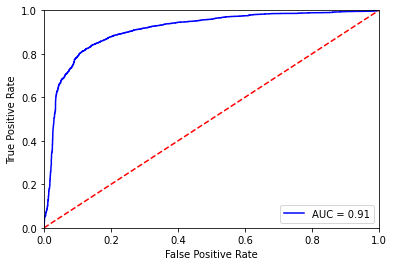

test_auc=0.909986552176749
test_accuracy=0.8485164753242881
confision_mat=[[3254  363]
 [ 653 2437]]


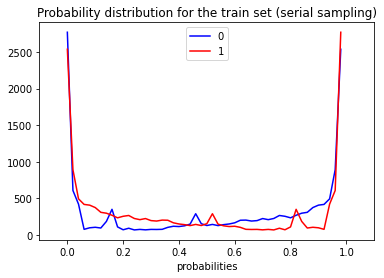

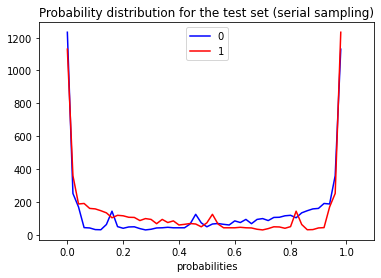

In [17]:
#dividing columns into numeric and string ones
num_columns=['fileSize', 'transferTime', 'queuingTime']
str_columns=['cellName']

#String Indexer and One Hot Encoder implementation
from pyspark.ml.feature import (StringIndexer, OneHotEncoder)
string_indexer=[ StringIndexer(inputCol=x, outputCol=x+'_StringIndexer', handleInvalid='skip') for x in str_columns]
one_hot_encoder=[OneHotEncoder(inputCol=f"{x}_StringIndexer", outputCol=f"{x}_OneHotEncoder") for x in str_columns]

#Vector Assembler implementation
from pyspark.ml.feature import VectorAssembler
assembler_input=[x for x in num_columns]
assembler_input+=[f"{x}_OneHotEncoder" for x in str_columns]
vector_assembler=VectorAssembler(inputCols=assembler_input, outputCol='features')

#splitting selected data on train and test samples (serial_df) 
train, test= serial_df.randomSplit([0.7,0.3],seed=7)

#designation of stages for Pipline
stages=[]
stages+=string_indexer
stages+=one_hot_encoder
stages+=[vector_assembler]

#Pipline model creation
from pyspark.ml import Pipeline
pipeline=Pipeline().setStages(stages)
model=pipeline.fit(train)

#transforming the train sample 
X_train=model.transform(train)
X_train.createOrReplaceTempView("X_train")
data=sqlContext.sql("select distinct(features),label from X_train")

#training Logistic Regression
from pyspark.ml.classification import LogisticRegression
lr=LogisticRegression().fit(data)


#transforming test sample
X_test=model.transform(test)
predicts=lr.transform(X_test)

#getting probabilitis, preidctions and actual labels 
probas=np.array(predicts.select('probability').collect())
lbls=np.array(predicts.select('label').collect())
preds=np.array(predicts.select('prediction').collect())
probas_1=[]
for proba in probas:
    probas_1.append(proba[0][1])
    
#calculating parametrs for ROC-curve plotting   
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(lbls, probas_1)

#calculating auc score
roc_auc = metrics.auc(fpr, tpr)

#ROC-curve plotting   
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#calculating confusion matrix and model accuracy  
conf_mat=metrics.confusion_matrix(lbls,preds)
accuracy=metrics.accuracy_score(lbls,preds)


print('test_auc={}\ntest_accuracy={}\nconfision_mat={}'.format(roc_auc,accuracy,conf_mat))

#probability distributions plotting
predicts_train=lr.transform(X_train)
probas1=np.array(predicts_train.select('probability').collect())
prob_negative1=[]
prob_positive1=[]
for proba1 in probas1:
    prob_negative1.append(proba1[0][0])
    prob_positive1.append(proba1[0][1])
prob_negative1=np.array(prob_negative1)
prob_positive1=np.array(prob_positive1)

probas=np.array(predicts.select('probability').collect())
prob_negative=[]
prob_positive=[]
for proba in probas:
    prob_negative.append(proba[0][0])
    prob_positive.append(proba[0][1])
prob_negative=np.array(prob_negative)
prob_positive=np.array(prob_positive)

neg_train=np.histogram(prob_negative1,50)
pos_train=np.histogram(prob_positive1,50)
neg_test=np.histogram(prob_negative,50)
pos_test=np.histogram(prob_positive,50)

plt.figure()
plt.plot(neg_train[1][:len(neg_train[1])-1],neg_train[0], color='blue', label='0')
plt.plot(pos_train[1][:len(pos_train[1])-1],pos_train[0], color='red', label='1')
plt.xlim([-0.1,1.1])
plt.xlabel('probabilities')
plt.title('Probability distribution for the train set (serial sampling)')
plt.legend()

plt.figure()
plt.plot(neg_test[1][:len(neg_test[1])-1],neg_test[0], color='blue', label='0')
plt.plot(pos_test[1][:len(pos_test[1])-1],pos_test[0], color='red', label='1')
plt.xlim([-0.1,1.1])
plt.xlabel('probabilities')
plt.title('Probability distribution for the test set (serial sampling)')
plt.legend()

Full code of the model implementation and evaluation for random sampling:

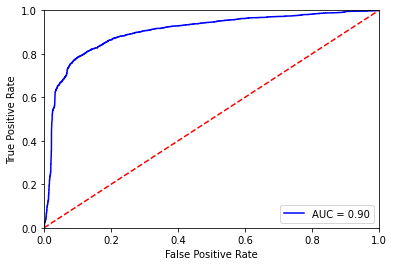

test_auc=0.9018747838981391
test_accuracy=0.8462682129051442
confision_mat=[[3349  311]
 [ 723 2343]]


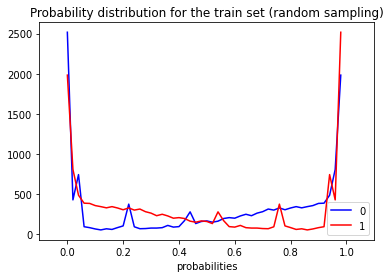

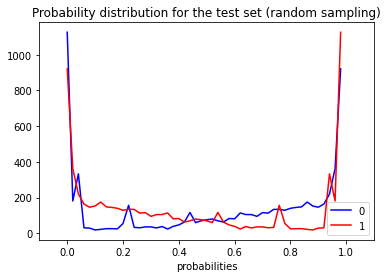

In [18]:
#dividing columns into numeric and string ones
num_columns=['fileSize', 'transferTime', 'queuingTime']
str_columns=['cellName']

#String Indexer and One Hot Encoder implementation
from pyspark.ml.feature import (StringIndexer, OneHotEncoder)
string_indexer=[ StringIndexer(inputCol=x, outputCol=x+'_StringIndexer', handleInvalid='skip') for x in str_columns]
one_hot_encoder=[OneHotEncoder(inputCol=f"{x}_StringIndexer", outputCol=f"{x}_OneHotEncoder") for x in str_columns]

#Vector Assembler implementation
from pyspark.ml.feature import VectorAssembler
assembler_input=[x for x in num_columns]
assembler_input+=[f"{x}_OneHotEncoder" for x in str_columns]
vector_assembler=VectorAssembler(inputCols=assembler_input, outputCol='features')

#splitting selected data on train and test samples (rand_df) 
train, test= rand_df.randomSplit([0.7,0.3],seed=7)

#designation of stages for Pipline
stages=[]
stages+=string_indexer
stages+=one_hot_encoder
stages+=[vector_assembler]

#Pipline model creation
from pyspark.ml import Pipeline
pipeline=Pipeline().setStages(stages)
model=pipeline.fit(train)

#transforming the train sample 
X_train=model.transform(train)
X_train.createOrReplaceTempView("X_train")
data=sqlContext.sql("select distinct(features),label from X_train")

#training Logistic Regression
from pyspark.ml.classification import LogisticRegression
lr=LogisticRegression().fit(data)


#transforming test sample
X_test=model.transform(test)
predicts=lr.transform(X_test)

#getting probabilitis, preidctions and actual labels 
probas=np.array(predicts.select('probability').collect())
lbls=np.array(predicts.select('label').collect())
preds=np.array(predicts.select('prediction').collect())
probas_1=[]
for proba in probas:
    probas_1.append(proba[0][1])
    
#calculating parametrs for ROC-curve plotting   
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(lbls, probas_1)

#calculating auc score
roc_auc = metrics.auc(fpr, tpr)

#ROC-curve plotting   
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#calculating confusion matrix and model accuracy  
conf_mat=metrics.confusion_matrix(lbls,preds)
accuracy=metrics.accuracy_score(lbls,preds)


print('test_auc={}\ntest_accuracy={}\nconfision_mat={}'.format(roc_auc,accuracy,conf_mat))

#probability distributions plotting
predicts_train=lr.transform(X_train)
probas1=np.array(predicts_train.select('probability').collect())
prob_negative1=[]
prob_positive1=[]
for proba1 in probas1:
    prob_negative1.append(proba1[0][0])
    prob_positive1.append(proba1[0][1])
prob_negative1=np.array(prob_negative1)
prob_positive1=np.array(prob_positive1)

probas=np.array(predicts.select('probability').collect())
prob_negative=[]
prob_positive=[]
for proba in probas:
    prob_negative.append(proba[0][0])
    prob_positive.append(proba[0][1])
prob_negative=np.array(prob_negative)
prob_positive=np.array(prob_positive)

neg_train=np.histogram(prob_negative1,50)
pos_train=np.histogram(prob_positive1,50)
neg_test=np.histogram(prob_negative,50)
pos_test=np.histogram(prob_positive,50)

plt.figure()
plt.plot(neg_train[1][:len(neg_train[1])-1],neg_train[0], color='blue', label='0')
plt.plot(pos_train[1][:len(pos_train[1])-1],pos_train[0], color='red', label='1')
plt.xlim([-0.1,1.1])
plt.xlabel('probabilities')
plt.title('Probability distribution for the train set (random sampling)')
plt.legend()

plt.figure()
plt.plot(neg_test[1][:len(neg_test[1])-1],neg_test[0], color='blue', label='0')
plt.plot(pos_test[1][:len(pos_test[1])-1],pos_test[0], color='red', label='1')
plt.xlim([-0.1,1.1])
plt.xlabel('probabilities')
plt.title('Probability distribution for the test set (random sampling)')
plt.legend()

Following observations can be done from the results:
* Scores and ROC-curves look quite similar for both types of selection. We suppose that this is an exceptional case, in more common and complicated situations such behavior is unlikely to be observed. 

* ROC-curves are a bit wiggled in some places. This fact can be explained by not enough statistics due to the not much amount of input data. However, our case is not critical since most parts are smooth. 

* If you look at the confusion matrices, you can notice that the model with the random sampling is a bit better in predicting `background` instances since TP and FN values are higher than the ones for the model with the serial sampling. While the latter is better in predicting `signal` due to the higher TN and FP values.

One non-obvious and essential issue is whether the chosen value of the model's threshold is appropriate. Let's consider model with the random sampling as an example. As was said before, we selected 0.5 as the threshold value for determing `background` instances, this means that decision boundaries (black dotted lines) split probability disrtibutions on approximately equal parts (look at figures below), therefore, the model will predict `background` and warn users frequently, that sometimes may be inconvenient.

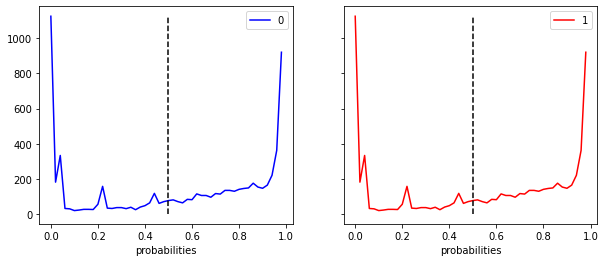

In [43]:
#plot of probability distributions for random sampling with default background threshold
fig, (ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(10,4))
ax1.plot(neg_test[1][:len(neg_test[1])-1],neg_test[0], color='blue', label='0')
ax1.plot([0.5,0.5],[0,np.max(neg_test[0])],'k--')
ax1.set_xlabel('probabilities')
ax1.legend('0')
ax2.plot(pos_test[1][:len(pos_test[1])-1],neg_test[0], color='red', label='0')
ax2.plot([0.5,0.5],[0,np.max(neg_test[0])],'k--')
ax2.set_xlabel('probabilities')
ax2.legend('1')

To avoid such situations, we can increase the threshold value for `background` determining, for instance, to 0.8, the threshold value for `signal` determining will decrease to 1-0.8=0.2. Decision boundaries will shift from the middle and less part of instances will be predicted as `background` (look at figures below). Of course, due to the `background` threshold rise, accuracy of the model might be reduced, however, with high probability, the model's reliability would be increased. If we get a warning about breakdowns in dCache from the model with stronger requirements to `background` instances, we will be much more sure that something is really going wrong and we should start taking action to figure out what was happened.  

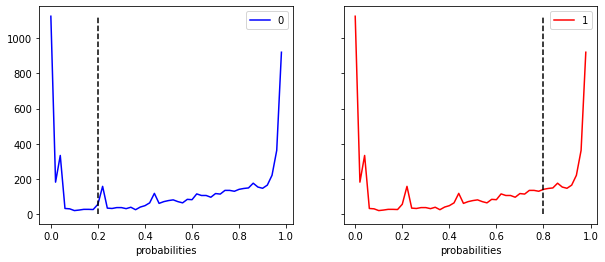

In [44]:
#plot of probability distributions for random sampling with higher background threshold
fig, (ax1,ax2)=plt.subplots(1,2,sharey=True,figsize=(10,4))
ax1.plot(neg_test[1][:len(neg_test[1])-1],neg_test[0], color='blue', label='0')
ax1.plot([0.2,0.2],[0,np.max(neg_test[0])],'k--')
ax1.set_xlabel('probabilities')
ax1.legend('0')
ax2.plot(pos_test[1][:len(pos_test[1])-1],neg_test[0], color='red', label='0')
ax2.plot([0.8,0.8],[0,np.max(neg_test[0])],'k--')
ax2.set_xlabel('probabilities')
ax2.legend('1')

Unfortunately, due to the lack of time, we did not investigate this issue fully. Optimal value for the `background` threshold was not found.

# **4. Conclusions**
Several main conclusions can be drawn from the results.
1. We managed to implement machine learning model able to distinguish signal and background instances with suitable accuracy, approximately 85 % for each sampling way.
2. Testing scores (accuracy, auc) and ROC-curve look very similar for both types of sampling. We are pretty sure that such behavior is not typical in general. In serial sampling, data, with high probability, have a particular sequential structure, that can contribute to the distribution of input data, while in random sampling there is no such problem. Why is in our case no manifestation of described effect - is on more question to investigate.
3. It is needed to investigate in more detail which value of threshold should be chosen for distinguishing signal and background. Optimal value, cutting off the doubtful `background` instances and, at the same time, preserving meaningful ones, should be found.

# **5. Discussion**
In this project, as disscussed we were able to successfully implement a ML algorithm on a Spark framework. However, there were many things which we were unable to achieve due to various constrains. Some ideas which were thought out during the project but we were unable to perform include-
* Determining the signal and background data in a better way by performing some statistical tests like Chi Square test etc.
* Doing more rigorous feature selection by performing more traditional Data selection processes.
* Implementing more complex ML algorithm

# **6. References**

1. Logistic regression: https://spark.apache.org/docs/latest/mllib-linear-methods.html#logistic-regression; https://www.pdfdrive.com/applied-logistic-regression-e172207141.html

2. Apache Spark documentation: https://spark.apache.org/

3. Apache Spark blog by AWS: https://aws.amazon.com/big-data/what-is-spark/

4. Machine Learning Definition: https://mitsloan.mit.edu/ideas-made-to-matter/machine-learning-explained

5. ML types: https://www.geeksforgeeks.org/introduction-machine-learning/

6. 
